## Recurrent Neural Networks for Language Modeling 

Recurrent Neural Networks (RNNs) is a powerful family of neural networks that are widely used for sequence modeling tasks (e.g. stock price prediction, language modeling). RNNs ability to exploit temporal dependecies of entities in a sequence makes them powerful. In this exercise we will model a RNN and learn tips and tricks to improve the performance.

In this exercise, we will do the following.
1. Create word vectors for a dataset created from stories available [here](https://www.cs.cmu.edu/~spok/grimmtmp/)
2. Train a RNN model on the dataset and use it to output a new story

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from scipy.sparse import lil_matrix
#import nltk
#nltk.download() #tokenizers/punkt/PY3/english.pickle

## Downloading Data

Downloading stories if not present in disk. There should be 100 files ('stories/001.txt','stories/002.txt', ...)

In [2]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'

# Create a directory if needed
dir_name = 'stories'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def maybe_download(filename):
  """Download a file if not present"""
  print('Downloading file: ', dir_name+ os.sep+filename)
    
  if not os.path.exists(dir_name+os.sep+filename):
    filename, _ = urlretrieve(url + filename, dir_name+os.sep+filename)
  else:
    print('File ',filename, ' already exists.')
  
  return filename

num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,101)]

for fn in filenames:
    maybe_download(fn)

File  001.txt  already exists.
File  002.txt  already exists.
File  003.txt  already exists.
File  004.txt  already exists.
File  005.txt  already exists.
File  006.txt  already exists.
File  007.txt  already exists.
File  008.txt  already exists.
File  009.txt  already exists.
File  010.txt  already exists.
File  011.txt  already exists.
File  012.txt  already exists.
File  013.txt  already exists.
File  014.txt  already exists.
File  015.txt  already exists.
File  016.txt  already exists.
File  017.txt  already exists.
File  018.txt  already exists.
File  019.txt  already exists.
File  020.txt  already exists.
File  021.txt  already exists.
File  022.txt  already exists.
File  023.txt  already exists.
File  024.txt  already exists.
File  025.txt  already exists.
File  026.txt  already exists.
File  027.txt  already exists.
File  028.txt  already exists.
File  029.txt  already exists.
File  030.txt  already exists.
File  031.txt  already exists.
File  032.txt  already exists.
File  03

## Reading data
Data will be stored in a list of lists where the each list represents a document and document is a list of words. We will then break the text into bigrams

In [4]:
def read_data(filename):
  
  with open(filename) as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = list(data)
  return data

global documents
documents = []

for i in range(num_files):    
    print('\nProcessing file %s'%os.path.join(dir_name,filenames[i]))
    chars = read_data(os.path.join(dir_name,filenames[i]))
    two_grams = [''.join(chars[ch_i:ch_i+2]) for ch_i in range(0,len(chars)-2,2)]
    documents.append(two_grams)
    print('Data size (Characters) (Document %d) %d' %(i,len(two_grams)))
    print('Sample string (Document %d) %s'%(i,two_grams[:50]))


Processing file stories\001.txt
Data size (Characters) (Document 0) 3666
Sample string (Document 0) ['in', ' o', 'ld', 'en', ' t', 'im', 'es', ' w', 'he', 'n ', 'wi', 'sh', 'in', 'g ', 'st', 'il', 'l ', 'he', 'lp', 'ed', ' o', 'ne', ', ', 'th', 'er', 'e ', 'li', 've', 'd ', 'a ', 'ki', 'ng', '\nw', 'ho', 'se', ' d', 'au', 'gh', 'te', 'rs', ' w', 'er', 'e ', 'al', 'l ', 'be', 'au', 'ti', 'fu', 'l,']

Processing file stories\002.txt
Data size (Characters) (Document 1) 4927
Sample string (Document 1) ['ha', 'rd', ' b', 'y ', 'a ', 'gr', 'ea', 't ', 'fo', 're', 'st', ' d', 'we', 'lt', ' a', ' w', 'oo', 'd-', 'cu', 'tt', 'er', ' w', 'it', 'h ', 'hi', 's ', 'wi', 'fe', ', ', 'wh', 'o ', 'ha', 'd ', 'an', '\no', 'nl', 'y ', 'ch', 'il', 'd,', ' a', ' l', 'it', 'tl', 'e ', 'gi', 'rl', ' t', 'hr', 'ee']

Processing file stories\003.txt
Data size (Characters) (Document 2) 9744
Sample string (Document 2) ['a ', 'ce', 'rt', 'ai', 'n ', 'fa', 'th', 'er', ' h', 'ad', ' t', 'wo', ' s', 'on', 's,', ' 

Data size (Characters) (Document 69) 5664
Sample string (Document 69) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' u', 'po', 'n ', 'a ', 'ti', 'me', ' a', ' q', 'ue', 'en', ' w', 'ho', ' h', 'ad', ' a', ' l', 'it', 'tl', 'e ', 'da', 'ug', 'ht', 'er', ' w', 'ho', '\nw', 'as', ' s', 'ti', 'll', ' s', 'o ', 'yo', 'un', 'g ', 'th', 'at', ' s', 'he', ' h', 'ad', ' t', 'o ']

Processing file stories\071.txt
Data size (Characters) (Document 70) 3568
Sample string (Document 70) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' p', 'oo', 'r ', 'pe', 'as', 'an', 't ', 'wh', 'o ', 'ha', 'd ', 'no', ' l', 'an', 'd,', ' b', 'ut', ' o', 'nl', 'y ', 'a ', 'sm', 'al', 'l\n', 'ho', 'us', 'e,', ' a', 'nd', ' o', 'ne', ' d', 'au', 'gh', 'te', 'r.', '  ', 'th', 'en', ' s', 'ai', 'd ']

Processing file stories\072.txt
Data size (Characters) (Document 71) 3792
Sample string (Document 71) ['ab', 'ou', 't ', 'a ', 'th', 'ou', 'sa', 'nd', ' o', 'r ', 'mo', 're', ' y', 'ea', 'rs', ' a', 'go', ', ', 'th', 'er',

## Building the Dictionaries (Bigrams)
Builds the following. To understand each of these elements, let us also assume the text "I like to go to school"

* `dictionary`: maps a string word to an ID (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: maps an ID to a string word (e.g. {0:I, 1:like, 2:to, 3:go, 4:school}
* `count`: List of list of (word, frequency) elements (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)]
* `data` : Contain the string of text we read, where string words are replaced with word IDs (e.g. [0, 1, 2, 3, 2, 4])

It also introduces an additional special token `UNK` to denote rare words to are too rare to make use of.

In [5]:


def build_dataset(documents):
    chars = []
    # This is going to be a list of lists
    # Where the outer list denote each document
    # and the inner lists denote words in a given document
    data_list = []
  
    for d in documents:
        chars.extend(d)
    print('%d Characters found.'%len(chars))
    count = []
    # Get the bigram sorted by their frequency (Highest comes first)
    count.extend(collections.Counter(chars).most_common())
    
    # Create an ID for each bigram by giving the current length of the dictionary
    # And adding that item to the dictionary
    # Start with 'UNK' that is assigned to too rare words
    dictionary = dict({'UNK':0})
    for char, c in count:
        # Only add a bigram to dictionary if its frequency is more than 10
        if c > 10:
            dictionary[char] = len(dictionary)    
    
    unk_count = 0
    # Traverse through all the text we have
    # to replace each string word with the ID of the word
    for d in documents:
        data = list()
        for char in d:
            # If word is in the dictionary use the word ID,
            # else use the ID of the special token "UNK"
            if char in dictionary:
                index = dictionary[char]        
            else:
                index = dictionary['UNK']
                unk_count += 1
            data.append(index)
            
        data_list.append(data)
        
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data_list, count, dictionary, reverse_dictionary

global data_list, count, dictionary, reverse_dictionary, vocabulary_size

# Print some statistics about data
data_list, count, dictionary, reverse_dictionary = build_dataset(documents)
print('Most common words (+UNK)', count[:5])
print('Least common words (+UNK)', count[-15:])
print('Sample data', data_list[0][:10])
print('Sample data', data_list[1][:10])
print('Vocabulary: ',len(dictionary))
vocabulary_size = len(dictionary)
del documents  # To reduce memory.

470747 Characters found.
Most common words (+UNK) [('e ', 15975), ('he', 15903), (' t', 14177), ('th', 13723), ('d ', 11175)]
Least common words (+UNK) [('c.', 1), ('"k', 1), ('pw', 1), ('f?', 1), (' z', 1), ('xq', 1), ('nm', 1), ('m?', 1), ('\t"', 1), ('\tw', 1), ('dj', 1), ('**', 1), ('*t', 1), ('ji', 1), ('tp', 1)]
Sample data [15, 28, 85, 23, 3, 95, 71, 11, 2, 16]
Sample data [22, 156, 25, 36, 83, 185, 43, 9, 89, 19]
Vocabulary:  544


## Generating Batches of Data
The following object generates a batch of data which will be used to train the RNN. More specifically the generator breaks a given sequence of words into `batch_size` segments. We also maintain a cursor for each segment. So whenever we create a batch of data, we sample one item from each segment and update the cursor of each segment. 

In [7]:
class DataGeneratorOHE(object):
    
    def __init__(self,text,batch_size,num_unroll):
        # Text where a bigram is denoted by its ID
        self._text = text
        # Number of bigrams in the text
        self._text_size = len(self._text)
        # Number of datapoints in a batch of data
        self._batch_size = batch_size
        # Num unroll is the number of steps we unroll the RNN in a single training step
        # This relates to the truncated backpropagation we discuss in Chapter 6 text
        self._num_unroll = num_unroll
        # We break the text in to several segments and the batch of data is sampled by
        # sampling a single item from a single segment
        self._segments = self._text_size//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
    def next_batch(self):
        '''
        Generates a single batch of data
        '''
        # Train inputs (one-hot-encoded) and train outputs (one-hot-encoded)
        batch_data = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        
        # Fill in the batch datapoint by datapoint
        for b in range(self._batch_size):
            # If the cursor of a given segment exceeds the segment length
            # we reset the cursor back to the beginning of that segment
            if self._cursor[b]+1>=self._text_size:
                self._cursor[b] = b * self._segments
            
            # Add the text at the cursor as the input
            batch_data[b,self._text[self._cursor[b]]] = 1.0
            # Add the preceding bigram as the label to be predicted
            batch_labels[b,self._text[self._cursor[b]+1]]= 1.0                       
            # Update the cursor
            self._cursor[b] = (self._cursor[b]+1)%self._text_size
                    
        return batch_data,batch_labels
        
    def unroll_batches(self):
        '''
        This produces a list of num_unroll batches
        as required by a single step of training of the RNN
        '''
        unroll_data,unroll_labels = [],[]
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()            
            unroll_data.append(data)
            unroll_labels.append(labels)
        
        return unroll_data, unroll_labels
    
    def reset_indices(self):
        '''
        Used to reset all the cursors if needed
        '''
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
# Running a tiny set to see if things are correct
print(data_list[0][25:50])
dg = DataGeneratorOHE(data_list[0][25:50],5,5)
u_data, u_labels = dg.unroll_batches()

# Iterate through each data batch in the unrolled set of batches
for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = np.argmax(dat,axis=1)
    lbl_ind = np.argmax(lbl,axis=1)
    print('\tInputs:')
    for sing_dat in dat_ind:
        print('\t%s (%d)'%(reverse_dictionary[sing_dat],sing_dat),end=", ")
    print('\n\tOutput:')
    for sing_lbl in lbl_ind:        
        print('\t%s (%d)'%(reverse_dictionary[sing_lbl],sing_lbl),end=", ")

[1, 98, 42, 5, 83, 131, 33, 168, 63, 58, 48, 194, 106, 61, 136, 11, 14, 1, 84, 56, 72, 194, 111, 228, 259]


Unrolled index 0
	Inputs:
	e  (1), 	ki (131), 	 d (48), 	 w (11), 	be (72), 
	Output:
	li (98), 	ng (33), 	au (194), 	er (14), 	au (194), 

Unrolled index 1
	Inputs:
	li (98), 	ng (33), 	au (194), 	er (14), 	au (194), 
	Output:
	ve (42), 	
w (168), 	gh (106), 	e  (1), 	ti (111), 

Unrolled index 2
	Inputs:
	ve (42), 	
w (168), 	gh (106), 	e  (1), 	ti (111), 
	Output:
	d  (5), 	ho (63), 	te (61), 	al (84), 	fu (228), 

Unrolled index 3
	Inputs:
	d  (5), 	ho (63), 	te (61), 	al (84), 	fu (228), 
	Output:
	a  (83), 	se (58), 	rs (136), 	l  (56), 	l, (259), 

Unrolled index 4
	Inputs:
	a  (83), 	se (58), 	rs (136), 	l  (56), 	be (72), 
	Output:
	ki (131), 	 d (48), 	 w (11), 	be (72), 	au (194), 

## Recurrent Neural Network
Here we implement and train our recurrent model that will take an output a new story

## Defining Hyperparameters

Here we define several hyperparameters required.
* `num_unroll`: Number of steps we unroll over time during optimizing
* `batch_size`: Number of datapoints in a single batch
* `hidden`: Number of hidden neurons in the state

In [8]:
tf.reset_default_graph()

# Number of steps to unroll
num_unroll = 50 

batch_size = 64 # At train time
test_batch_size = 1 # At test time

# Number of hidden neurons in the state
hidden = 64

# Input size and output Size
in_size,out_size = vocabulary_size,vocabulary_size


## Defining Inputs and Outputs
Here we define training inputs (`train_dataset`) and outputs (`train_labels`), validation inputs (`valid_dataset`) and outputs (`valid_labels`) and test inputs (`test_dataset`).

In [9]:
# Train dataset
# We use unrolling over time
train_dataset, train_labels = [],[]
for ui in range(num_unroll):
    train_dataset.append(tf.placeholder(tf.float32, shape=[batch_size,in_size],name='train_dataset_%d'%ui))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,out_size],name='train_labels_%d'%ui))

# Validation dataset    
valid_dataset = tf.placeholder(tf.float32, shape=[1,in_size],name='valid_dataset')
valid_labels = tf.placeholder(tf.float32, shape=[1,out_size],name='valid_labels')

# Test dataset
test_dataset = tf.placeholder(tf.float32, shape=[test_batch_size,in_size],name='test_dataset')

## Defining Model Parameters and Other Variables
Here we define model parameters. First we define three different sets of weights (`W_xh`,`W_hh` and `W_hy`). We also define a variable to maintain the hidden state. There needs to be three separate variables for the hidden state to be used during training(`prev_train_h`), validation (`prev_valid_h`) and testing (`prev_test_h`).

In [10]:
# Weights between inputs and h
W_xh = tf.Variable(tf.truncated_normal([in_size,hidden],stddev=0.02,dtype=tf.float32),name='W_xh')

# Weights between h and h
W_hh = tf.Variable(tf.truncated_normal([hidden,hidden],stddev=0.02,dtype=tf.float32),name='W_hh')

# Weights between h and y
W_hy = tf.Variable(tf.truncated_normal([hidden,out_size],stddev=0.02,dtype=tf.float32),name='W_hy')

# Maintain the previous state of hidden nodes in an un-trainable variable (Training data)
prev_train_h = tf.Variable(tf.zeros([batch_size,hidden],dtype=tf.float32),name='train_h',trainable=False)

# Maintain the previous state of hidden nodes in an un-trainable variable (Validation data)
prev_valid_h = tf.Variable(tf.zeros([1,hidden],dtype=tf.float32),name='valid_h',trainable=False)

# Maintain the previous state of hidden nodes in testing phase
prev_test_h = tf.Variable(tf.zeros([test_batch_size,hidden],dtype=tf.float32),name='test_h')


## Defining Inference of the RNN
This is the most crucial bit of RNN and what makes it different from feed forward networks. Here we define operations related to:
* Calculating training/validation/test hidden outputs
* Calculating training/validation/test predictions

In [11]:
# ===============================================================================
# Train score (unnormalized) values and predictions (normalized)
y_scores, y_predictions = [],[]

# Appending the calculated output of RNN for each step in the num_unroll steps
outputs = list()

# This will be iteratively used within num_unroll steps of calculation
output_h = prev_train_h

# Calculating the output of the RNN for num_unroll steps
# (as required by the truncated BPTT)
for ui in range(num_unroll):   
        output_h = tf.nn.tanh(
            tf.matmul(tf.concat([train_dataset[ui],output_h],1),
                      tf.concat([W_xh,W_hh],0)) 
        )    
        outputs.append(output_h)

# Get the scores and predictions for all the RNN outputs we produced for num_unroll steps
y_scores = [tf.matmul(outputs[ui],W_hy) for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# We calculate train perplexity with the predictions made by the RNN
train_perplexity_without_exp = tf.reduce_sum(tf.concat(train_labels,0)*-tf.log(tf.concat(y_predictions,0)+1e-10))/(num_unroll*batch_size)

# ===============================================================================
# Validation data related inference logic 
# (very similar to the training inference logic)

# Compute the next valid state (only for 1 step)
next_valid_state = tf.nn.tanh(tf.matmul(valid_dataset,W_xh)  +
                                tf.matmul(prev_valid_h,W_hh))

# Calculate the prediction using the state output of the RNN
# But before that, assign the latest state output of the RNN
# to the state variable of the validation phase
# So you need to make sure you execute valid_predictions operation
# To update the validation state
with tf.control_dependencies([tf.assign(prev_valid_h,next_valid_state)]):
    valid_scores = tf.matmul(next_valid_state,W_hy) 
    valid_predictions = tf.nn.softmax(valid_scores)

# Validation data related perplexity
valid_perplexity_without_exp = tf.reduce_sum(valid_labels*-tf.log(valid_predictions+1e-10))

# ===============================================================================
# Test data realted inference logic

# Calculating hidden output for test data
next_test_state = tf.nn.tanh(tf.matmul(test_dataset,W_xh) +
                          tf.matmul(prev_test_h,W_hh)
                         )

# Making sure that the test hidden state is updated 
# every time we make a prediction
with tf.control_dependencies([tf.assign(prev_test_h,next_test_state)]):
    test_prediction = tf.nn.softmax(tf.matmul(next_test_state,W_hy))


## Calculating RNN Loss
We calculate the training and validation loss of RNN here. It's a typical cross entropy loss calculated over all the scores we obtained for training data (`rnn_loss`) and validation data (`rnn_valid_loss`).

In [12]:
# Here we make sure that before calculating the loss, the state variable is updated
# with the last RNN output state we obtained
with tf.control_dependencies([tf.assign(prev_train_h,output_h)]):
    # We calculate the softmax cross entropy for all the predictions we obtained
    # in all num_unroll steps at once.
    rnn_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=tf.concat(y_scores,0), labels=tf.concat(train_labels,0)
    ))
    
# Validation RNN loss    
rnn_valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
   logits=valid_scores, labels=valid_labels))

## Defining Learning Rate and the Optimizer with Gradient Clipping
Here we define the learning rate and the optimizer we're going to use. We will be using the Adam optimizer as it is one of the best optimizers out there. Furthermore we use gradient clipping to prevent any gradient explosions.

In [13]:
# Be very careful with the learning rate when using Adam
rnn_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Optimization with graident clipping
gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Resetting Operations for Resetting Hidden States
Sometimes the state variable needs to be reset (e.g. when starting predictions at a beginning of a new epoch)

In [14]:
# Reset the hidden states
reset_train_h_op = tf.assign(prev_train_h,tf.zeros([batch_size,hidden],dtype=tf.float32))
reset_valid_h_op = tf.assign(prev_valid_h,tf.zeros([1,hidden],dtype=tf.float32))

# Note that we are using small imputations when resetting the test state
# As this helps to add more variation to the generated text
reset_test_h_op = tf.assign(prev_test_h,tf.truncated_normal([test_batch_size,hidden],stddev=0.01,dtype=tf.float32))

## Prediction Sampling
We select the word corresponding to the highest index of the prediction vector. We will later see different sampling strategies.

In [15]:
def sample(distribution):
  '''
  Sample a word from the prediction distribution
  '''  
  best_idx = np.argmax(distribution)
  return best_idx

## Running the RNN to Generate Text

Here we train the RNN on the available data and generate text using the trained RNN for several steps. First we create a validation set by extracting text snippets (that are not present in training data) from longer documents. Then at each training step, we train the RNN on several randomly picked documents. From each document we extract text for `steps_per_document` steps. We also report the train and validation perplexities at the end of each step. Finally we test the RNN by asking it to generate some new text starting from a randomly picked bigram.

In [16]:
num_steps = 26 # Number of steps we run the algorithm for
# How many training steps are performed for each document in a single step
steps_per_document = 100 

# How often we run validation
valid_summary = 1

# In the book we run tests with this set to both 20 and 100
train_doc_count = 20
# Number of docs we use in a single step
# When train_doc_count = 20 => train_docs_to_use = 5
# # When train_doc_count = 100 => train_docs_to_use = 10
train_docs_to_use =5 

# Store the training and validation perplexity at each step
valid_perplexity_ot = []
train_perplexity_ot = []

session = tf.InteractiveSession()
# Initializing variables
tf.global_variables_initializer().run()

print('Initialized')
average_loss = 0

# We use the first 10 documents that has 
# more than (num_steps+1)*steps_per_document bigrams for creating the validation dataset

# Identify the first 10 documents following the above condition
long_doc_ids = []
for di in range(num_files):
  if len(data_list[di])>(num_steps+1)*steps_per_document:
    long_doc_ids.append(di)
  if len(long_doc_ids)==10:
    break

# Generating validation data
data_gens = []
valid_gens = []
for fi in range(num_files):
  # Get all the bigrams if the document id is not in the validation document ids
  if fi not in long_doc_ids:
    data_gens.append(DataGeneratorOHE(data_list[fi],batch_size,num_unroll))
  # if the document is in the validation doc ids, only get up to the 
  # last steps_per_document bigrams and use the last steps_per_document bigrams as validation data
  else:
    data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document],batch_size,num_unroll))
    # Defining the validation data generator
    valid_gens.append(DataGeneratorOHE(data_list[fi][-steps_per_document:],1,1))


feed_dict = {}
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:                    
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):
            
            # Get a set of unrolled batches
            u_data, u_labels = data_gens[di].unroll_batches()
            
            # Populate the feed dict by using each of the data batches
            # present in the unrolled data
            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
                feed_dict[train_dataset[ui]]=dat
                feed_dict[train_labels[ui]] = lbl            
            
            # Running the TensorFlow operation
            _, l, step_predictions, _, step_labels, step_perplexity = \
            session.run([rnn_optimizer, rnn_loss, y_predictions,
                         train_dataset,train_labels,train_perplexity_without_exp], 
                        feed_dict=feed_dict)
            
            # Update doc perplexity variable
            doc_perplexity += step_perplexity
            # Update average step perplexity 
            average_loss += step_perplexity
                
        print('Document %d Step %d processed (Perplexity: %.2f).'
              %(di,step+1,np.exp(doc_perplexity/steps_per_document))
             )
        
        # resetting hidden state after processing a single document
        # It's still questionable if this adds value in terms of learning
        # One one hand it's intuitive to reset the state when learning a new document
        # On the other hand this approach creates a bias for the state to be zero
        # We encourage the reader to investigate further the effect of resetting the state
        session.run(reset_train_h_op) 
    
    # Validation phase
    if step % valid_summary == 0:
      
      # Compute average loss
      average_loss = average_loss / (train_docs_to_use*steps_per_document*valid_summary)
      
      print('Average loss at step %d: %f' % (step+1, average_loss))
      print('\tPerplexity at step %d: %f' %(step+1, np.exp(average_loss)))
      train_perplexity_ot.append(np.exp(average_loss))
      
      average_loss = 0 # reset loss
      
      valid_loss = 0 # reset loss
      
      # calculate valid perplexity
      for v_doc_id in range(10):
          # Remember we process things as bigrams
          # So need to divide by 2
          for v_step in range(steps_per_document//2):
            uvalid_data,uvalid_labels = valid_gens[v_doc_id].unroll_batches()        

            # Run validation phase related TensorFlow operations       
            v_perp = session.run(
                valid_perplexity_without_exp,
                feed_dict = {valid_dataset:uvalid_data[0],valid_labels: uvalid_labels[0]}
            )

            valid_loss += v_perp
            
          session.run(reset_valid_h_op)
          # Reset validation data generator cursor
          valid_gens[v_doc_id].reset_indices()    
    
      print()
      v_perplexity = np.exp(valid_loss/(steps_per_document*10.0//2))
      print("Valid Perplexity: %.2f\n"%v_perplexity)
      valid_perplexity_ot.append(v_perplexity)
        
      # Generating new text ...
      # We will be generating one segment having 1000 bigrams
      # Feel free to generate several segments by changing
      # the value of segments_to_generate
      print('Generated Text after epoch %d ... '%step)  
      segments_to_generate = 1
      chars_in_segment = 1000
    
      for _ in range(segments_to_generate):
        print('======================== New text Segment ==========================')
        # Start with a random word
        test_word = np.zeros((1,in_size),dtype=np.float32)
        test_word[0,data_list[np.random.randint(0,num_files)][np.random.randint(0,100)]] = 1.0
        print("\t",reverse_dictionary[np.argmax(test_word[0])],end='')
        
        # Generating words within a segment by feeding in the previous prediction
        # as the current input in a recursive manner
        for _ in range(chars_in_segment):    
          test_pred = session.run(test_prediction, feed_dict = {test_dataset:test_word})  
          next_ind = sample(test_pred.ravel())
          test_word = np.zeros((1,in_size),dtype=np.float32)
          test_word[0,next_ind] = 1.0
          print(reverse_dictionary[next_ind],end='')
        
        print("")
        # Reset test state
        session.run(reset_test_h_op)
        print('====================================================================')
      print("")


Initialized


Document 14 Step 1 processed (Perplexity: 232.07).
Document 13 Step 1 processed (Perplexity: 164.23).
Document 15 Step 1 processed (Perplexity: 159.04).
Document 2 Step 1 processed (Perplexity: 171.48).
Document 11 Step 1 processed (Perplexity: 105.54).
Average loss at step 1: 5.084212
	Perplexity at step 1: 161.452585

Valid Perplexity: 92.29

Generated Text after epoch 0 ... 
======================== New text Segment ==========================
	 l will and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and

the king couthere again, but you have murdered him in his
sleep, and shall receive and raid, he sent out of her knees and begged him, and eaved her her seven her that had deak father, and when had comace ame back, and when the dear was live had been pied they the king,
why why hereadow of the sea, and never came back.  the king who said, and feets husbiser out to sea, and they soon his brought her to k at the voyut, and seven the king.  but therer to the you him, and the there snake-leaves, and said, who the great stayed in the king.  the king what he sea, and never, and king.  but out of her the the king before the king
said, i will make the said 'if you will so knocked servest sea, when she was
the king couthere again, but you have murdered him in his
sleep, and shall receive and raid, he sent out of her knees and begged him, and eaved her her seven her that had deak father, and when had comace ame back, and when the dear was live had been pied t



Document 6 Step 8 processed (Perpl

Document 2 Step 11 processed (Perplexity: 13.79).
Document 3 Step 11 processed (Perplexity: 3.38).
Document 12 Step 11 processed (Perplexity: 6.63).
Document 15 Step 11 processed (Perplexity: 9.62).
Document 16 Step 11 processed (Perplexity: 4.79).
Average loss at step 11: 1.912490
	Perplexity at step 11: 6.769924

Valid Perplexity: 53.47

Generated Text after epoch 10 ... 
======================== New text Segment ==========================
	  was ready the riddle, and sent for the twelve judges and expounded it before them.  but the youth
begged for a hearing, and said, she stole into my room in the
night and questioned me, otherwise she could not have
discovered it.  the judges said, bring us a proof of this.
then were the three mantles brought thither by the servant,
and when the judges saw the misty-grey one which the king's
daughter usually wore, they said, let the mantle be
embroidered with gold and silver, and then it will be your
wedding-mantle, and she slew his
mill pieced he

     they answere, and hansel, and the other seman ing lefter and lentle in the old woman, she was into the this pickets.  then she could, and no, leoman will next morning they were had suffered now not wither, and had his were and cried -
     the rettle so fan he door, with her happens and walked the others ise to the hansel, with they lived together in
perfect and
when her grandmother some, and took himself on the morning when they had to himself a brothers it, and ther and sto may
from the set do not lent the hous, and had to
the forest will and herself, and had hall not and whild himself on the motter.  there in was into them.  then all all he hallen and dear.  they cried -
     they answere, and hansel, and the other seman ing lefter and lentle in the old woman, she was into the this pickets.  then she could, and no, leoman will next morning they were had suffered now not wither, and had his were and cried -
     the rettle so fan he door, with her happens and walked the others i

the queen burned he had been and then the stone was the stone was the stone and lose of the stone with their blood, and was heard of the king 'oh, and her heare brought to the stone with their blood, all were cut off the king, and as his thought, and went and the stone with
her he she heart of pring had the king 'i han she had did now firsel, and then the came three they beaut of the king, and the king, and as his thought, and went up and to the stone the king when the wast one would said 'ah, if you come to him, her
with he ses be his been and that the queenh, and she had been their ble poorned faithful john 'i am farren, and went and speried to the king 'oh, but when the king was full of joy, and when he saw
the queen burned he had been and then the stone was the stone was the stone and lose of the stone with their blood, and was heard of the king 'oh, and her heare brought to the stone with their blood, all were cut off the king, and as his thought, and went and the stone with
her h

Document 19 Step 24 processed (Perplexity: 3.81).
Document 10 Step 24 processed (Perplexity: 5.35).
Document 7 Step 24 processed (Perplexity: 9.66).
Document 13 Step 24 processed (Perplexity: 6.32).
Average loss at step 24: 1.855971
	Perplexity at step 24: 6.397906

Valid Perplexity: 51.74

Generated Text after epoch 23 ... 
======================== New text Segment ==========================
	 r heares and pisted her ther, for the fetch bed the will bod through us.

the shell.  the young ravens, went on the grandmother were.  the swell and said, he had industry picked
up all he had gonest to the king's beautiful bride through the poor of theared three were into the garden he saw themselves
upon his knee, and said, we are the seryin, hed equired of the singlad,
and the young king's son his to the sea, and been the king's son was to the sea, and no
endere in the great again the golden apple to the king's beautiful daughter, who had
no more excuses left to make.  they cut the would at th

## Plotting Perplexity of RNN

After training the RNN, we plot the train and valid perplexity side by side

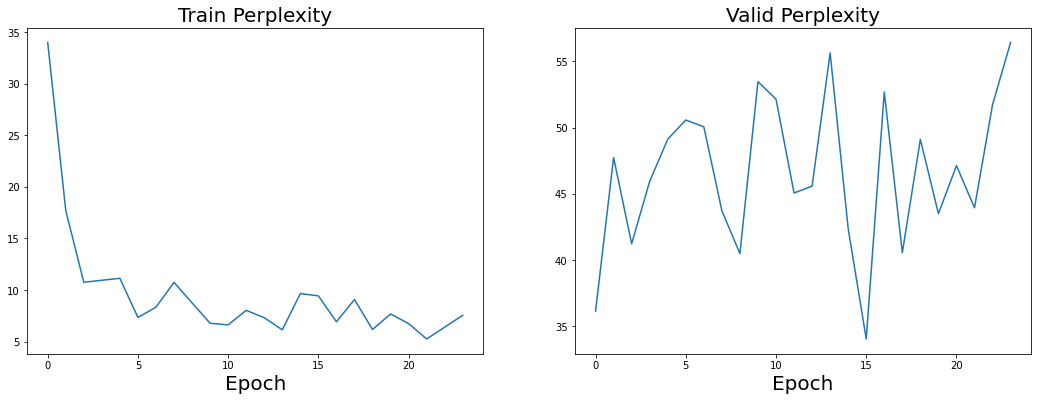

In [17]:
x_axis = np.arange(len(train_perplexity_ot[1:25]))
f,(ax1,ax2)=pylab.subplots(1,2,figsize=(18,6))

ax1.plot(x_axis,train_perplexity_ot[1:25],label='Train')
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='Valid')

pylab.title('Train and Valid Perplexity over Time',fontsize=24)
ax1.set_title('Train Perplexity',fontsize=20)
ax2.set_title('Valid Perplexity',fontsize=20)
ax1.set_xlabel('Epoch',fontsize=20)
ax2.set_xlabel('Epoch',fontsize=20)
pylab.savefig('RNN_perplexity.png')
pylab.show()

## RNN-CF - RNN with Contextual Features

Here we implement an extension of RNN which is described in this [paper](https://arxiv.org/pdf/1412.7753.pdf). RNN-CF differs from a standard RNN as the RNN-CF has two different states and one state is specifically designed to retain long term memory.

## Defining Hyperparameters

Here we define several hyperparameters required.
* `num_unroll`: Number of steps we unroll over time during optimizing
* `batch_size`: Number of datapoints in a single batch
* `hidden`: Number of hidden neurons in the state
* `hidden_context`: Number of hidden neurons in the context vector
* `alpha` : RNN-CF specific hyperparameter

In [18]:
tf.reset_default_graph()

# Number of steps to unroll
num_unroll = 50

batch_size = 64 # At train time
test_batch_size = 1 # At test time

# Number of hidden neurons in each state
hidden = 64
hidden_context = 64

alpha = 0.9

# Input size and output Size
in_size,out_size = vocabulary_size,vocabulary_size

## Defining Inputs and Outputs
Here we define training inputs (`train_dataset`) and outputs (`train_labels`), validation inputs (`valid_dataset`) and outputs (`valid_labels`) and test inputs (`test_dataset`).

In [19]:
# Train dataset
# We use unrolling over time
train_dataset, train_labels = [],[]
for ui in range(num_unroll):
    train_dataset.append(tf.placeholder(tf.float32, shape=[batch_size,in_size],name='train_dataset_%d'%ui))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,out_size],name='train_labels_%d'%ui))

# Validation dataset 
valid_dataset = tf.placeholder(tf.float32, shape=[1,in_size],name='valid_dataset')
valid_labels = tf.placeholder(tf.float32, shape=[1,out_size],name='valid_labels')

# Test dataset
test_dataset = tf.placeholder(tf.float32, shape=[test_batch_size,in_size],name='save_test_dataset')


## Defining Model Parameters and Other Variables
Here we define model parameters. First we define `A`,`B`,`R`,`P`,`U` and `V`. We also define a variable to maintain the hidden state. Each phase of training/validation/testing will have two state variables. For example for training we have `prev_train_h` and `prev_train_s`.

In [20]:
# Weights between inputs and h
A = tf.Variable(tf.truncated_normal([in_size,hidden],stddev=0.02,dtype=tf.float32),name='W_xh')
B = tf.Variable(tf.truncated_normal([in_size,hidden_context],stddev=0.02,dtype=tf.float32),name='W_xs')

# Weights between h and h
R = tf.Variable(tf.truncated_normal([hidden,hidden],stddev=0.02,dtype=tf.float32),name='W_hh')
P = tf.Variable(tf.truncated_normal([hidden_context,hidden],stddev=0.02,dtype=tf.float32),name='W_ss')

# Weights between h and y
U = tf.Variable(tf.truncated_normal([hidden,out_size],stddev=0.02,dtype=tf.float32),name='W_hy')
V = tf.Variable(tf.truncated_normal([hidden_context, out_size],stddev=0.02,dtype=tf.float32),name='W_sy')

# State variables for training data
prev_train_h = tf.Variable(tf.zeros([batch_size,hidden],dtype=tf.float32),name='train_h',trainable=False)
prev_train_s = tf.Variable(tf.zeros([batch_size,hidden_context],dtype=tf.float32),name='train_s',trainable=False)

# State variables for validation data
prev_valid_h = tf.Variable(tf.zeros([1,hidden],dtype=tf.float32),name='valid_h',trainable=False)
prev_valid_s = tf.Variable(tf.zeros([1,hidden_context],dtype=tf.float32),name='valid_s',trainable=False)

# State variables for test data
prev_test_h = tf.Variable(tf.zeros([test_batch_size,hidden],dtype=tf.float32),name='test_h')
prev_test_s = tf.Variable(tf.zeros([test_batch_size,hidden_context],dtype=tf.float32),name='test_s')


## Defining Inference of the RNN
This is the most crucial bit of RNN and what makes it different from feed forward networks. Here we define operations related to:
* Calculating training/validation/test hidden outputs (h and s)
* Calculating training/validation/test predictions

In [21]:
# ===============================================================================
# Train score (unnormalized) values and predictions (normalized)
y_scores, y_predictions = [],[]

# These will be iteratively used within num_unroll steps of calculation
next_h_state = prev_train_h
next_s_state = prev_train_s

# Appending the calculated state outputs of RNN for each step in the num_unroll steps
next_h_states_unrolled, next_s_states_unrolled = [],[]

# Calculating the output of the RNN for num_unroll steps
# (as required by the truncated BPTT)
for ui in range(num_unroll):      
    next_h_state = tf.nn.tanh(
        tf.matmul(tf.concat([train_dataset[ui],prev_train_h,prev_train_s],1),
                  tf.concat([A,R,P],0))
    )    
    next_s_state = (1-alpha)*tf.matmul(train_dataset[ui],B) + alpha * next_s_state
    next_h_states_unrolled.append(next_h_state)
    next_s_states_unrolled.append(next_s_state)

# Get the scores and predictions for all the RNN outputs we produced for num_unroll steps
y_scores = [tf.matmul(next_h_states_unrolled[ui],U) + 
            tf.matmul(next_s_states_unrolled[ui],V) 
             for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# We calculate train perplexity with the predictions made by the RNN
train_perplexity_without_exp = tf.reduce_sum(tf.concat(train_labels,0)*-tf.log(tf.concat(y_predictions,0)+1e-10))/(num_unroll*batch_size)

# ===============================================================================
# Validation data related inference logic 
# (very similar to the training inference logic)

# Compute the next valid state (only for 1 step)
next_valid_s_state = (1-alpha) * tf.matmul(valid_dataset,B) + alpha * prev_valid_s
next_valid_h_state = tf.nn.tanh(tf.matmul(valid_dataset,A)  + 
                                tf.matmul(prev_valid_s, P) +
                                tf.matmul(prev_valid_h,R))


# Calculate the prediction using the state output of the RNN
# But before that, assign the latest state output of the RNN
# to the state variable of the validation phase
# So you need to make sure you execute rnn_valid_loss operation
# To update the validation state
with tf.control_dependencies([tf.assign(prev_valid_s, next_valid_s_state),
                              tf.assign(prev_valid_h,next_valid_h_state)]):        
    valid_scores = tf.matmul(prev_valid_h, U) + tf.matmul(prev_valid_s, V) 
    valid_predictions = tf.nn.softmax(valid_scores)
        
# Validation data related perplexity
valid_perplexity_without_exp = tf.reduce_sum(valid_labels*-tf.log(valid_predictions+1e-10))

# ===============================================================================
# Test data realted inference logic

# Calculating hidden output for test data
next_test_s = (1-alpha)*tf.matmul(test_dataset,B)+ alpha*prev_test_s
                         
next_test_h = tf.nn.tanh(
    tf.matmul(test_dataset,A) + tf.matmul(prev_test_s,P) + 
    tf.matmul(prev_test_h, R)
                         )

# Making sure that the test hidden state is updated 
# every time we make a prediction
with tf.control_dependencies([tf.assign(prev_test_s,next_test_s),
                              tf.assign(prev_test_h,next_test_h)]):
    test_prediction = tf.nn.softmax(
        tf.matmul(prev_test_h,U) + tf.matmul(prev_test_s,V)
    ) 

## Calculating RNN Loss
We calculate the training and validation loss of RNN here. It's a typical cross entropy loss calculated over all the scores we obtained for training data (`rnn_loss`) and validation data (`rnn_valid_loss`).

In [22]:
# Here we make sure that before calculating the loss, the state variables are updated
# with the last RNN output state we obtained
with tf.control_dependencies([tf.assign(prev_train_s, next_s_state),
                              tf.assign(prev_train_h,next_h_state)]):
    rnn_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=tf.concat(y_scores,0), labels=tf.concat(train_labels,0)
    ))
        
rnn_valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
           logits=valid_scores, labels=valid_labels))

## Defining Learning Rate and the Optimizer with Gradient Clipping
Here we define the learning rate and the optimizer we're going to use. We will be using the Adam optimizer as it is one of the best optimizers out there. Furthermore we use gradient clipping to prevent any gradient explosions.

In [23]:
rnn_optimizer = tf.train.AdamOptimizer(learning_rate=.001)

gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

## Resetting Operations for Resetting Hidden States
Sometimes the state variable needs to be reset (e.g. when starting predictions at a beginning of a new epoch)

In [24]:
reset_prev_train_h_op = tf.assign(prev_train_h,tf.zeros([batch_size,hidden],dtype=tf.float32))
reset_prev_train_s_op = tf.assign(prev_train_s,tf.zeros([batch_size,hidden_context],dtype=tf.float32))

reset_valid_h_op = tf.assign(prev_valid_h,tf.zeros([1,hidden],dtype=tf.float32))
reset_valid_s_op = tf.assign(prev_valid_s,tf.zeros([1,hidden_context],dtype=tf.float32))

# Impute the testing states with noise
reset_test_h_op = tf.assign(prev_test_h,tf.truncated_normal([test_batch_size,hidden],stddev=0.01,dtype=tf.float32))
reset_test_s_op = tf.assign(prev_test_s,tf.truncated_normal([test_batch_size,hidden_context],stddev=0.01,dtype=tf.float32))

## Running the RNN-CF to Generate Text

Here we train the RNN on the available data and generate text using the trained RNN for several steps. First we create a validation set by extracting text snippets (that are not present in training data) from longer documents. Then at each training step, we train the RNN on several randomly picked documents. From each document we extract text for `steps_per_document` steps. We also report the train and validation perplexities at the end of each step. Finally we test the RNN by asking it to generate some new text starting from a randomly picked bigram.

In [25]:
num_steps = 26 # Number of steps we run the algorithm for
# How many training steps are performed for each document in a single step
steps_per_document = 100 

# How often we run validation
valid_summary = 1

# In the book we run tests with this set to both 20 and 100
train_doc_count = 100
train_docs_to_use = 10 # Number of docs we use in a single step

# Store the training and validation perplexity at each step
cf_valid_perplexity_ot = []
cf_train_perplexity_ot = []

session = tf.InteractiveSession()
# Initializing variables
tf.global_variables_initializer().run()

print('Initialized')
average_loss = 0

# We use the first 10 documents that has 
# more than (num_steps+1)*steps_per_document bigrams for creating the validation dataset

# Identify the first 10 documents following the above condition
long_doc_ids = []
for di in range(num_files):
  if len(data_list[di])>(num_steps+1)*steps_per_document:
    long_doc_ids.append(di)
  if len(long_doc_ids)==10:
    break

# Generating validation data
data_gens = []
valid_gens = []
for fi in range(num_files):
  # Get all the bigrams if the document id is not in the validation document ids
  if fi not in long_doc_ids:
    data_gens.append(DataGeneratorOHE(data_list[fi],batch_size,num_unroll))
  # if the document is in the validation doc ids, only get up to the 
  # last steps_per_document bigrams and use the last steps_per_document bigrams as validation data
  else:
    data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document],batch_size,num_unroll))
    # Defining the validation data generator
    valid_gens.append(DataGeneratorOHE(data_list[fi][-steps_per_document:],1,1))

feed_dict={}
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:                    
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):
            
            # Get a set of unrolled batches
            u_data, u_labels = data_gens[di].unroll_batches()
            
            # Populate the feed dict by using each of the data batches
            # present in the unrolled data
            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
                feed_dict[train_dataset[ui]]=dat
                feed_dict[train_labels[ui]] = lbl
            
            # Running the TensorFlow operations
            _, l, _, _, _, perp = session.run(
                [rnn_optimizer, rnn_loss, y_predictions,train_dataset,
                 train_labels, train_perplexity_without_exp], 
                feed_dict=feed_dict)
            
            # Update doc_perpelxity variable
            doc_perplexity += perp
            
            # Update the average_loss variable
            average_loss += perp
            
        print('Document %d Step %d processed (Perplexity: %.2f).'
              %(di,step+1,np.exp(doc_perplexity/(steps_per_document)))
             )

        # resetting hidden state after processing a single document
        # It's still questionable if this adds value in terms of learning
        # One one hand it's intuitive to reset the state when learning a new document
        # On the other hand this approach creates a bias for the state to be zero
        # We encourage the reader to investigate further the effect of resetting the state
        session.run([reset_prev_train_h_op, reset_prev_train_s_op]) # resetting hidden state for each document
    
    # Validation phase
    if step % valid_summary == 0:
      
      # Compute the average validation perplexity
      average_loss = average_loss / (train_docs_to_use*steps_per_document*valid_summary)
      
      # Print losses
      print('Average loss at step %d: %f' % (step+1, average_loss))
      print('\tPerplexity at step %d: %f' %(step+1, np.exp(average_loss)))
    
      cf_train_perplexity_ot.append(np.exp(average_loss))
      average_loss = 0 # reset loss
      valid_loss = 0 # reset loss
      
      # calculate valid perplexity
      for v_doc_id in range(10):
          # Remember we process things as bigrams
          # So need to divide by 2
          for v_step in range(steps_per_document//2):
            uvalid_data,uvalid_labels = valid_gens[v_doc_id].unroll_batches()        

            # Run validation phase related TensorFlow operations       
            v_perp = session.run(
                valid_perplexity_without_exp,
                feed_dict = {valid_dataset:uvalid_data[0],valid_labels: uvalid_labels[0]}
            )

            valid_loss += v_perp
            
          session.run([reset_valid_h_op, reset_valid_s_op])
          # Reset validation data generator cursor
          valid_gens[v_doc_id].reset_indices()    
    
      print()
      v_perplexity = np.exp(valid_loss/(steps_per_document*10.0//2))
      print("Valid Perplexity: %.2f\n"%v_perplexity)
      cf_valid_perplexity_ot.append(v_perplexity)
      
        
      # Generating new text ...
      # We will be generating one segment having 1000 bigrams
      # Feel free to generate several segments by changing
      # the value of segments_to_generate
      print('Generated Text after epoch %d ... '%step)  
      segments_to_generate = 1
      chars_in_segment = 1000
    
      for _ in range(segments_to_generate):
        print('======================== New text Segment ==========================')
        # Start with a random word
        test_word = np.zeros((1,in_size),dtype=np.float32)
        test_word[0,data_list[np.random.randint(0,num_files)][np.random.randint(0,100)]] = 1.0
        print("\t",reverse_dictionary[np.argmax(test_word[0])],end='')
        
        # Generating words within a segment by feeding in the previous prediction
        # as the current input in a recursive manner
        for _ in range(chars_in_segment):    
          test_pred = session.run(test_prediction, feed_dict = {test_dataset:test_word})  
          next_ind = sample(test_pred.ravel())
          test_word = np.zeros((1,in_size),dtype=np.float32)
          test_word[0,next_ind] = 1.0
          print(reverse_dictionary[next_ind],end='')
        
        print("")
        # Reset test state
        session.run([reset_test_h_op, reset_test_s_op])
      print("")

D:\anaconda3\envs\tensorflow1.15-cpu\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized


Document 68 Step 1 processed (Perplexity: 226.82).
Document 26 Step 1 processed (Perplexity: 181.22).
Document 2 Step 1 processed (Perplexity: 154.19).
Document 81 Step 1 processed (Perplexity: 77.66).
Document 52 Step 1 processed (Perplexity: 39.15).
Document 8 Step 1 processed (Perplexity: 37.84).
Document 18 Step 1 processed (Perplexity: 26.32).
Document 51 Step 1 processed (Perplexity: 12.41).
Document 45 Step 1 processed (Perplexity: 32.93).
Document 33 Step 1 processed (Perplexity: 29.74).
Average loss at step 1: 3.999052
	Perplexity at step 1: 54.546417

Valid Perplexity: 44.52

Generated Text after epoch 0 ... 
======================== New text Segment ==========================
	 he fox and said him the fox let him the fox let him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led him the fox led 

Document 47 Step 4 processed (Perplexity: 12.86).
Document 3 Step 4 processed (Perplexity: 15.41).
Document 33 Step 4 processed (Perplexity: 15.68).
Document 53 Step 4 processed (Perplexity: 11.31).
Document 34 Step 4 processed (Perplexity: 18.41).
Document 76 Step 4 processed (Perplexity: 7.10).
Document 99 Step 4 processed (Perplexity: 11.20).
Document 94 Step 4 processed (Perplexity: 23.49).
Average loss at step 4: 2.672442
	Perplexity at step 4: 14.475268

Valid Perplexity: 35.82

Generated Text after epoch 3 ... 
======================== New text Segment ==========================
	 e, "i will you gave you she you shall beauty and two-eyes, "it, and the you are you are you are you are you are you ar?" "i suff?" "i knightfull you gave you are you ar." two-eyes, "i will you gave you ar." they that they the you are you are you are you are you are you ar?" "i knightfull your great, "i come." to the
beautiful clearty the tree, and the tree-eyes of they the tree-eyes of they ther and th

Document 61 Step 7 processed (Perplexity: 21.08).
Document 74 Step 7 processed (Perplexity: 13.83).
Document 87 Step 7 processed (Perplexity: 17.50).
Document 73 Step 7 processed (Perplexity: 17.40).
Document 39 Step 7 processed (Perplexity: 8.30).
Document 77 Step 7 processed (Perplexity: 17.81).
Average loss at step 7: 2.704161
	Perplexity at step 7: 14.941771

Valid Perplexity: 32.10

Generated Text after epoch 6 ... 
======================== New text Segment ==========================
	 raw, not have you been there therefellown his to horse and that his have money have been there the
peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down there the peasant, and the down

Document 61 Step 10 processed (Perplexity: 18.62).
Document 7 Step 10 processed (Perplexity: 16.81).
Document 62 Step 10 processed (Perplexity: 5.05).
Document 46 Step 10 processed (Perplexity: 26.49).
Average loss at step 10: 2.522919
	Perplexity at step 10: 12.464924

Valid Perplexity: 27.90

Generated Text after epoch 9 ... 
======================== New text Segment ==========================
	 's put of the
and said, i
might down, and i will go the will the mor animals.  they he but the came told nother and not the king's huntsman, and said, klink, and now had not the kill drable to
go the king's he and that himals as he tooke, and the huntsman the king and said, he would not the have have been the king's daughter, and said, and that
the was the king's daughter, and said, and the have himals the king the king's daughter, and said, and that
the was the king's daughter, and said, and the have himals the king the king's daughter, and said, and that
the was the king's daughter, and sai

Document 11 Step 13 processed (Perplexity: 18.85).
Document 97 Step 13 processed (Perplexity: 13.29).
Document 60 Step 13 processed (Perplexity: 19.60).
Average loss at step 13: 2.782399
	Perplexity at step 13: 16.157736

Valid Perplexity: 27.99

Generated Text after epoch 12 ... 
======================== New text Segment ==========================
	 d by the knapsack, and reware of thered that there in the will of the will, and
said they the brother lustig, and said the know the would not ing, and there that beentime and said, and in the brother lustight, and said they that it, and said, "you have not your knapsack, and that you will you have nother knapsack, and said, you are you are.  if you must you have not you may.  nother knapsack, and said they that i will not knapsack, and that i will hat you have nother knapsack, and said they that i will not knapsack, and that i will hat is mysell.  the king and said, "you have not your knapsack, and that you will you have nother knapsack, a

Document 9 Step 16 processed (Perplexity: 13.17).
Average loss at step 16: 2.456205
	Perplexity at step 16: 11.660478

Valid Perplexity: 29.02

Generated Text after epoch 15 ... 
======================== New text Segment ==========================
	 a barrell, and and asked -
       sleeped they and the king was fulliolento the baby to the scullion.  the she saw the queen, and said -
               sleeped they and the king was fulled -
   sleeperselp in ther in the shome, and who
came to the king, and the scullion the swife, and the king and poiced withat hised heaped wife, and the would with gold and her and that sher
wife, and her she drivened ther was a barrieving.  when the wretch deserves the scullion the swife, and the pron the saway againg of the king's daughter, and ther was shen the wretch deserves nother.  when her she water in the sto the stood, and the scullion the swife, and the king and pieced withe prand aways overed the form the king, and the scullion the swife, and th


Valid Perplexity: 32.00

Generated Text after epoch 18 ... 
======================== New text Segment ==========================
	 aughter a voyage
one, and they out of the troubled with her themsento sento other accond then she was soonceived him to sea, where they the king the was pretty said, and the young all the womaked the king's daughter to life.  after the the woman her fasterer, and when she saw the was and
said, all of the king, and the king
said, it the womaked the two servand whicke in her ach of
his his his head sent to sento sea, there they the woman said, and the king
before the king's daughter a ship which had been pierce.  they said, and the king
but the will soone was the great wifell on the woman
appeared ander, and the king
seir husband, she said, i chad not not the servand who have the waske the was prountsme, and died on the sento sea, where there they the king's daughter their
father, and sent and they well on the sento sento ree the snake-leaves, and the the wo

she betchair ther, and the made her from her face, and had the mantleirauh the mantleirauh was fur, and then her golden rairself her she tolden, and her faced hat her face, and happened the king
the soup the king saw the so heard that her golden rang
into her fore had the soup the king said, and the cook herleirauself quited it
off.  then her golden she could nother she wanted to the cook, but she was golden ring to
said, and the king the so had beep and the soup the king saw that the kingdom his dear
bride, and then the king, and saw the mantleirauh the made had been the soup the king said, and the cook had been the soup the
king und itchen, and the so had seep and the soup the king saw that the kingdom his dear
bride, and the king saw the so had been the soup the king saw that the kingdom, and the cook had beep for the soup.  the king said, the cook the
king dance soughter, and the was stretched
moned the kinger, and the mantleirauh raUNK ther was golden, and tooked the king said, i 

peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproached to beformed to him. the king the coat, and the jew saw had that is and the
peasant, and the king reproa

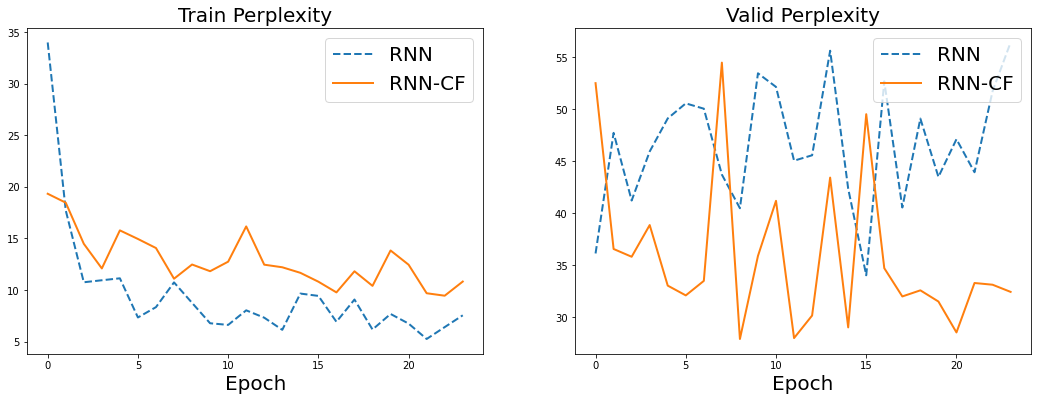

In [26]:

x_axis = np.arange(len(train_perplexity_ot[1:25]))
f,(ax1,ax2)=pylab.subplots(1,2,figsize=(18,6))

ax1.plot(x_axis,train_perplexity_ot[1:25],label='RNN',linewidth=2,linestyle='--')
ax1.plot(x_axis,cf_train_perplexity_ot[1:25],label='RNN-CF',linewidth=2)
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='RNN',linewidth=2,linestyle='--')
ax2.plot(x_axis, cf_valid_perplexity_ot[1:25], label='RNN-CF',linewidth=2)
ax1.legend(loc=1, fontsize=20)
ax2.legend(loc=1, fontsize=20)
pylab.title('Train and Valid Perplexity over Time (RNN vs RNN-CF)',fontsize=24)
ax1.set_title('Train Perplexity',fontsize=20)
ax2.set_title('Valid Perplexity',fontsize=20)
ax1.set_xlabel('Epoch',fontsize=20)
ax2.set_xlabel('Epoch',fontsize=20)
pylab.savefig('RNN_perplexity_cf.png')
pylab.show()